In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('data.csv')



Saving data.csv to data (1).csv


In [ ]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Kernel, RBF,Exponentiation,Sum



# New Section

In [ ]:
df_subset = df.head(554)
data = df_subset.drop(columns=['sku'])



In [ ]:
print(data)

     salesdate  price  unitsordered  sales  cogs  fba  reffee  adspend  \
0    2022/4/18  28.09            57   1601   707  469     240      109   
1    2022/4/19  29.29            56   1640   695  460     246       87   
2    2022/4/20  28.69            87   2496  1080  715     374      136   
3    2022/4/21  27.99            66   1847   819  543     277      121   
4    2022/4/22  29.09            62   1804   769  510     271       87   
..         ...    ...           ...    ...   ...  ...     ...      ...   
427   2023/7/5  27.89            51   1422   633  419     213       55   
428   2023/7/6  27.79            28    778   347  230     117       51   
429   2023/7/7  27.79            52   1445   645  427     217       37   
430   2023/7/8  25.39            11    279   137   90      42       39   
431   2023/7/9  27.99            14    392   174  115      59       19   

     profit  comp_1_price  ...   log_fba  log_cen_fba  cen_reffee  \
0        76         29.99  ...  6.150603  

In [ ]:
import datetime
def str_to_datetime(s):
    # Split the date string by either '-' or '/' to handle both formats
    split = s.split(s[4])
    year,month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year,month=month,day=day)
data['salesdate'] = data['salesdate'].apply(str_to_datetime)
data.index = data.pop('salesdate')

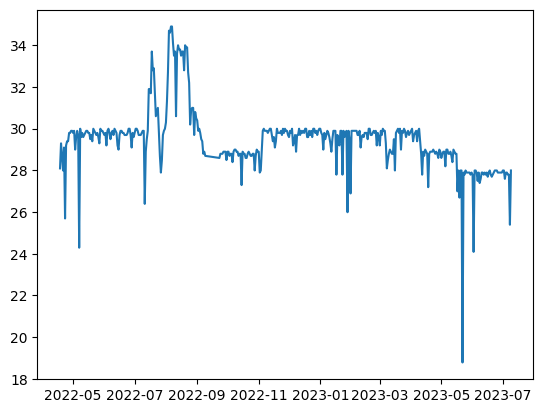

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])

Now we format the data into an LSTM

In [ ]:
kernel1 = Exponentiation(RBF(length_scale=1),exponent=2)
kernel2 = RBF(length_scale=5)
kernel = Sum(kernel1,kernel2)
gpr = GaussianProcessRegressor(kernel = kernel,random_state=0)
gpr1 = GaussianProcessRegressor(kernel=kernel1,random_state=0)
gpr2 = GaussianProcessRegressor(kernel=kernel2,random_state=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
target_col = data.columns[0]
feature_cols = data.columns[1:]
y = torch.tensor(data[[target_col]].values,dtype = torch.float32)
MaxData = torch.max(y)
x = torch.tensor(data[feature_cols].values,dtype = torch.float32)
x = torch.nan_to_num(x)
y = torch.nan_to_num(y)
x = torch.tensor(scaler.fit_transform(x),dtype = torch.float32)
y = torch.tensor(scaler.fit_transform(y),dtype = torch.float32)

In [ ]:
print(x[0:40,:].shape)
a = 200
x_train = x[0:a,:]
y_train = y[0:a,:]
x_test = x[a:,:]
y_test = y[a:,:]

torch.Size([40, 41])


In [ ]:

gpr1result = gpr1.fit(x_train,y_train)
gpr2result = gpr2.fit(x_train,y_train)
gprresult = gpr.fit(x_train,y_train)
print(gpr1result.score(x_train,y_train))
print(gpr2result.score(x_train,y_train))
print(gprresult.score(x_train,y_train))


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.999999999999902
1.0
0.9999999999998557


In [ ]:
y_pred,y_predstd = gprresult.predict(x_test,return_std=True)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
df = np.trace(gprresult.kernel_(gprresult.X_train_))
y_predstd = scaler.inverse_transform(y_predstd.reshape(-1,1))

upper_bound = y_pred + 1.96 *np.sqrt(y_predstd**2/df)
lower_bound = y_pred - 1.96 * np.sqrt(y_predstd**2/df)

y_pred1,y_pred1std = gpr1result.predict(x_test,return_std=True)
y_pred1 = scaler.inverse_transform(y_pred1.reshape(-1,1))
df1 = np.trace(gpr1result.kernel_(gprresult.X_train_))
y_pred1std = scaler.inverse_transform(y_pred1std.reshape(-1,1))
upper_bound1 = y_pred1 + 1.96 *np.sqrt(y_pred1std**2/df1)
lower_bound1 = y_pred1- 1.96 * np.sqrt(y_pred1std**2/df1)


y_pred2,y_pred2std = gpr2result.predict(x_test,return_std=True)
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred2std = scaler.inverse_transform(y_pred2.reshape(-1,1))
df2 = np.trace(gpr2result.kernel_(gprresult.X_train_))
upper_bound2 = y_pred2 + 1.96 *np.sqrt(y_pred2std**2/df2)
lower_bound2 = y_pred2 - 1.96 * np.sqrt(y_pred2std**2/df2)


This is just squared exponential

This is the RBF, just normal exponential

(-1.070300846894753, 42.582222852870316)

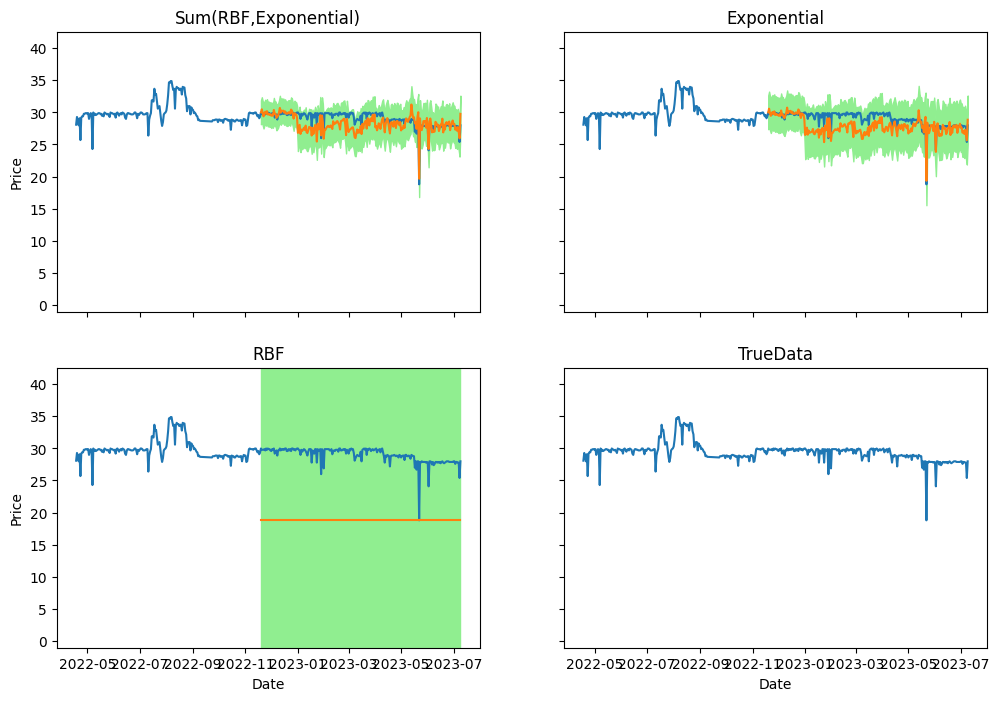

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
axes[0,0].plot(data.index,data['price'])
axes[0,1].plot(data.index,data['price'])
axes[1,0].plot(data.index,data['price'])
axes[1,1].plot(data.index,data['price'])

axes[0,0].set_ylabel('Price')
axes[1,0].set_ylabel('Price')
axes[1,0].set_xlabel('Date')
axes[1,1].set_xlabel('Date')

axes[0,0].set_title('Sum(RBF,Exponential)')
axes[0,1].set_title('Exponential')
axes[1,0].set_title('RBF')
axes[1,1].set_title('TrueData')

axes[0,0].plot(data.index[a:],y_pred)
axes[0,1].plot(data.index[a:],y_pred1)
axes[1,0].plot(data.index[a:],y_pred2)

axes[0,0].fill_between(data.index[a:], lower_bound.flatten(), upper_bound.flatten(), color='lightgreen')
axes[0,1].fill_between(data.index[a:], lower_bound1.flatten(), upper_bound1.flatten(), color='lightgreen')
axes[1,0].fill_between(data.index[a:], lower_bound2.flatten(), upper_bound2.flatten(),color='lightgreen')

axes[0,0].set_ylim(np.nanmin(y_pred1std)-20,np.nanmax(y_pred1std)+15)


Compaire Models


In [ ]:
from sklearn.metrics import mean_squared_error


def calculate_metrics(model, x_train, y_train, x_test, y_test):
    """Calculates and returns R-squared, MSE, RMSE, log-likelihood, AIC, and BIC for a given model."""

    # R-squared (training)
    r_squared_train = model.score(x_train, y_train)

    # Predictions and errors (test)
    y_pred_test = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)

    # Log-likelihood
    log_likelihood = model.log_marginal_likelihood_value_

    # Degrees of freedom (using trace of covariance matrix)
    degrees_of_freedom = np.trace(model.kernel_(model.X_train_))

    # AIC and BIC
    aic = -2 * log_likelihood + 2 * degrees_of_freedom
    bic = -2 * log_likelihood + degrees_of_freedom * np.log(x_train.shape[0])

    return {
        "R-squared (Train)": r_squared_train,
        "MSE (Test)": mse,
        "RMSE (Test)": rmse,
        "Log-likelihood": log_likelihood,
        "AIC": aic,
        "BIC": bic
    }

# Calculate metrics for each model
models = [gprresult, gpr1result, gpr2result]
model_names = ["gprresult", "gpr1result", "gpr2result"]
metrics_results = {}

for model, name in zip(models, model_names):
    metrics_results[name] = calculate_metrics(model, x_train, y_train, x_test, y_test)

# Print the results
print("Model Comparison:")
for name, metrics in metrics_results.items():
    print(f"\n--- {name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")


Model Comparison:

--- gprresult ---
R-squared (Train): 0.9999999999998557
MSE (Test): 0.006651026738935182
RMSE (Test): 0.08155382724884946
Log-likelihood: 333.3654664952038
AIC: 133.2690670095924
BIC: 1452.596013628807

--- gpr1result ---
R-squared (Train): 0.999999999999902
MSE (Test): 0.009298384597665323
RMSE (Test): 0.0964281317752518
Log-likelihood: 317.9821319377352
AIC: -235.96426387547035
BIC: 423.69920943413695

--- gpr2result ---
R-squared (Train): 1.0
MSE (Test): 0.4062348376421626
RMSE (Test): 0.6373655447560392
Log-likelihood: -232.9320706394223
AIC: 865.8641412788446
BIC: 1525.5276145884518


ArGpr

In [ ]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import pacf

In [ ]:
series = data
price_series = series["price"]
pacf_values = pacf(price_series, nlags=20, method='yw')

In [ ]:
# 95% confidence interval
n = len(price_series)
threshold = 1.96 / np.sqrt(n)

# get the first PACF less than the lags of threshold
optimal_p = np.where(np.abs(pacf_values) < threshold)[0][0]

print(optimal_p)
#The order should be 4

4


In [ ]:
X = np.array([price_series[i-optimal_p:i] for i in range(optimal_p, n)])
y = price_series[optimal_p:]

model = LinearRegression()
model.fit(X, y)

intercept = model.intercept_
coefficients = model.coef_

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 3.5165556300253478
Coefficients: [0.02172636 0.22269155 0.25726897 0.37871908]


In [ ]:
y_pred_ar = model.predict(X)
residuals_ar = y - y_pred_ar
data = data.loc[residuals_ar.index]
data['price'] = residuals_ar.values

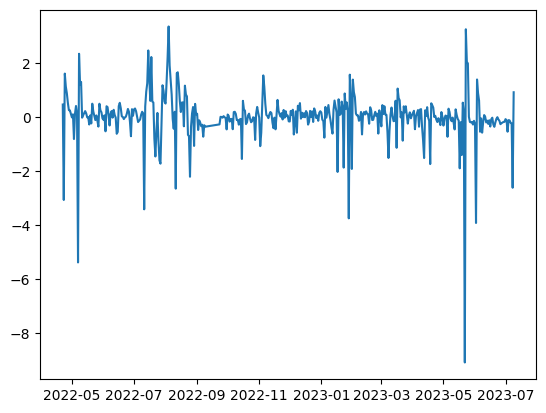

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data.index, data['price'])

Fit GPR for Residual

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
target_col = data.columns[0]
feature_cols = data.columns[1:]
y = torch.tensor(data[[target_col]].values,dtype = torch.float32)
MaxData = torch.max(y)
x = torch.tensor(data[feature_cols].values,dtype = torch.float32)
x = torch.nan_to_num(x)
y = torch.nan_to_num(y)
x = torch.tensor(scaler.fit_transform(x),dtype = torch.float32)
y = torch.tensor(scaler.fit_transform(y),dtype = torch.float32)

In [ ]:
print(x[0:40,:].shape)
a = 200
x_train = x[0:a,:]
y_train = y[0:a,:]
x_test = x[a:,:]
y_test = y[a:,:]

torch.Size([40, 41])


In [ ]:
gpr1result = gpr1.fit(x_train,y_train)
gpr2result = gpr2.fit(x_train,y_train)
gprresult = gpr.fit(x_train,y_train)
print(gpr1result.score(x_train,y_train))
print(gpr2result.score(x_train,y_train))
print(gprresult.score(x_train,y_train))

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0.9999999999999918
1.0
0.999999999999992


In [ ]:
y_pred,y_predstd = gprresult.predict(x_test,return_std=True)
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
df = np.trace(gprresult.kernel_(gprresult.X_train_))
y_predstd = scaler.inverse_transform(y_predstd.reshape(-1,1))

upper_bound = y_pred + 1.96 *np.sqrt(y_predstd**2/df)
lower_bound = y_pred - 1.96 * np.sqrt(y_predstd**2/df)

y_pred1,y_pred1std = gpr1result.predict(x_test,return_std=True)
y_pred1 = scaler.inverse_transform(y_pred1.reshape(-1,1))
df1 = np.trace(gpr1result.kernel_(gprresult.X_train_))
y_pred1std = scaler.inverse_transform(y_pred1std.reshape(-1,1))
upper_bound1 = y_pred1 + 1.96 *np.sqrt(y_pred1std**2/df1)
lower_bound1 = y_pred1- 1.96 * np.sqrt(y_pred1std**2/df1)


y_pred2,y_pred2std = gpr2result.predict(x_test,return_std=True)
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred2std = scaler.inverse_transform(y_pred2.reshape(-1,1))
df2 = np.trace(gpr2result.kernel_(gprresult.X_train_))
upper_bound2 = y_pred2 + 1.96 *np.sqrt(y_pred2std**2/df2)
lower_bound2 = y_pred2 - 1.96 * np.sqrt(y_pred2std**2/df2)

(-28.51794010900951, 17.64271705557026)

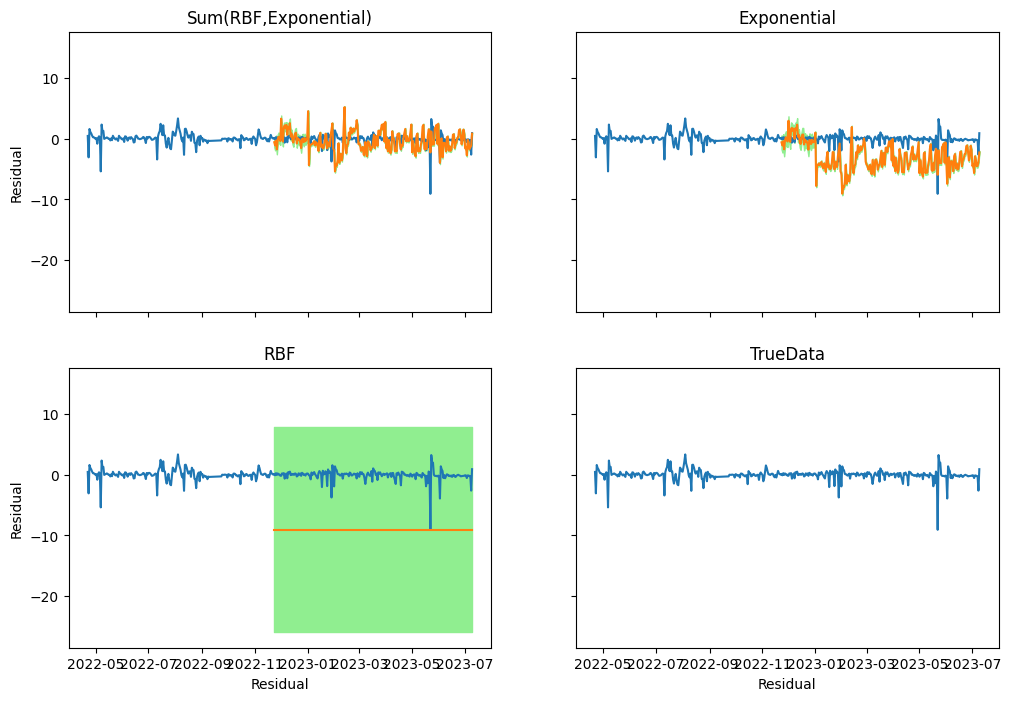

In [ ]:
fig,axes = plt.subplots(2,2,figsize=(12,8),sharex=True,sharey=True)
axes[0,0].plot(data.index,data['price'])
axes[0,1].plot(data.index,data['price'])
axes[1,0].plot(data.index,data['price'])
axes[1,1].plot(data.index,data['price'])

axes[0,0].set_ylabel('Residual')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('Residual')
axes[1,1].set_xlabel('Residual')

axes[0,0].set_title('Sum(RBF,Exponential)')
axes[0,1].set_title('Exponential')
axes[1,0].set_title('RBF')
axes[1,1].set_title('TrueData')

axes[0,0].plot(data.index[a:],y_pred)
axes[0,1].plot(data.index[a:],y_pred1)
axes[1,0].plot(data.index[a:],y_pred2)

axes[0,0].fill_between(data.index[a:], lower_bound.flatten(), upper_bound.flatten(), color='lightgreen')
axes[0,1].fill_between(data.index[a:], lower_bound1.flatten(), upper_bound1.flatten(), color='lightgreen')
axes[1,0].fill_between(data.index[a:], lower_bound2.flatten(), upper_bound2.flatten(),color='lightgreen')

axes[0,0].set_ylim(np.nanmin(y_pred1std)-20,np.nanmax(y_pred1std)+15)


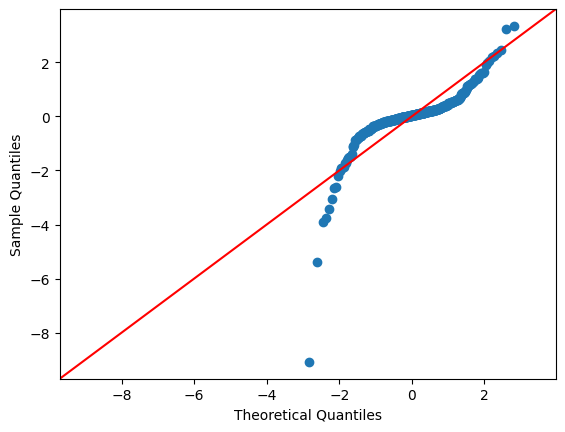

In [ ]:
# prompt: Plot a QQ plot for the  data['price']

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'data' and 'price_series' are defined as in the provided code.

# Create the QQ plot
fig = sm.qqplot(data['price'], line='45')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error


def calculate_metrics(model, x_train, y_train, x_test, y_test):
    """Calculates and returns R-squared, MSE, RMSE, log-likelihood, AIC, and BIC for a given model."""

    # R-squared (training)
    r_squared_train = model.score(x_train, y_train)

    # Predictions and errors (test)
    y_pred_test = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)

    # Log-likelihood
    log_likelihood = model.log_marginal_likelihood_value_

    # Degrees of freedom (using trace of covariance matrix)
    degrees_of_freedom = np.trace(model.kernel_(model.X_train_))

    # AIC and BIC
    aic = -2 * log_likelihood + 2 * degrees_of_freedom
    bic = -2 * log_likelihood + degrees_of_freedom * np.log(x_train.shape[0])

    return {
        "R-squared (Train)": r_squared_train,
        "MSE (Test)": mse,
        "RMSE (Test)": rmse,
        "Log-likelihood": log_likelihood,
        "AIC": aic,
        "BIC": bic
    }

# Calculate metrics for each model
models = [gprresult, gpr1result, gpr2result]
model_names = ["gprresult", "gpr1result", "gpr2result"]
metrics_results = {}

for model, name in zip(models, model_names):
    metrics_results[name] = calculate_metrics(model, x_train, y_train, x_test, y_test)

# Print the results
print("Model Comparison:")
for name, metrics in metrics_results.items():
    print(f"\n--- {name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")


Model Comparison:

--- gprresult ---
R-squared (Train): 0.999999999999992
MSE (Test): 0.020155885260247752
RMSE (Test): 0.1419714240974139
Log-likelihood: 74.42333286203083
AIC: 651.1533342759383
BIC: 1970.4802808951529

--- gpr1result ---
R-squared (Train): 0.9999999999999918
MSE (Test): 0.08857982825766177
RMSE (Test): 0.2976236352470377
Log-likelihood: 73.66628084180022
AIC: 252.66743831639957
BIC: 912.3309116260068

--- gpr2result ---
R-squared (Train): 1.0
MSE (Test): 0.5310363781946058
RMSE (Test): 0.7287224287714807
Log-likelihood: -238.64760348841756
AIC: 877.2952069768351
BIC: 1536.9586802864424
